In [1]:
%load_ext autoreload
%autoreload 2

# Applying CRIPS-DM Methodology to a Business Problem

## Dataset 1 - Predicting Customer Churn in the Telecomunication Provider

## 3. Modeling

### 3.4. Random Forest

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
X_train = pd.read_csv('../data/processed/SMOTE/X_train.csv')
y_train = pd.read_csv('../data/processed/SMOTE/y_train.csv')
X_val = pd.read_csv('../data/processed/SMOTE/X_val.csv')
y_val = pd.read_csv('../data/processed/SMOTE/y_val.csv')
X_test = pd.read_csv('../data/processed/SMOTE/X_test.csv')
y_test = pd.read_csv('../data/processed/SMOTE/y_test.csv')

In [4]:
y_train = y_train.values.ravel()
y_val = y_val.values.ravel()
y_test = y_test.values.ravel()

In [5]:
from sklearn.ensemble import RandomForestClassifier

In [6]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, classification_report, ConfusionMatrixDisplay
from joblib import dump

In [7]:
rf = RandomForestClassifier(random_state=8)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=8)

In [8]:
def random_forest(model):
    y_train_preds = model.predict(X_train)
    y_val_preds = model.predict(X_val)
    
    y_train_probs = model.predict_proba(X_train)[:, 1]
    y_val_probs = model.predict_proba(X_val)[:, 1]
    
    train_accuracy = accuracy_score(y_train, y_train_preds)
    train_precision = precision_score(y_train, y_train_preds)
    train_recall = recall_score(y_train, y_train_preds)
    train_f1 = f1_score(y_train, y_train_preds)
    train_roc_auc = roc_auc_score(y_train, y_train_probs)
    
    val_accuracy = accuracy_score(y_val, y_val_preds)
    val_precision = precision_score(y_val, y_val_preds)
    val_recall = recall_score(y_val, y_val_preds)
    val_f1 = f1_score(y_val, y_val_preds)
    val_roc_auc = roc_auc_score(y_val, y_val_probs)
    
    train_score = pd.DataFrame({
        'accuracy': train_accuracy,
        'precision': train_precision,
        'recall': train_recall,
        'f1-score': train_f1,
        'roc-auc': train_roc_auc}, index=['Training Set'])
    
    val_score = pd.DataFrame({
        'accuracy': val_accuracy,
        'precision': val_precision,
        'recall': val_recall,
        'f1-score': val_f1,
        'roc-auc': val_roc_auc}, index=['Validation Set'])

    score = pd.concat([train_score, val_score])
    print(score)
    
    
    ConfusionMatrixDisplay.from_estimator(model, X_train, y_train, normalize='true')
    ConfusionMatrixDisplay.from_estimator(model, X_val, y_val, normalize='true')                                     
    
    plt.figure()
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)
    
    plt.plot(fpr_train, tpr_train, label='Train ROC-curve')
    plt.plot(fpr_val, tpr_val, label='Validate ROC-curve')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-Curve')
    plt.legend()
    
    plt.show()
    
    rf_val = pd.DataFrame({'accuracy': val_accuracy,
                             'precision': val_precision,
                             'recall': val_recall,
                             'f1-score': val_f1,
                             'roc-auc': val_roc_auc}, index=['Random Forest'])
    
    return(rf_val)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    1.000000   1.000000  1.000000  1.000000  1.000000
Validation Set  0.888235   0.727273  0.333333  0.457143  0.793914


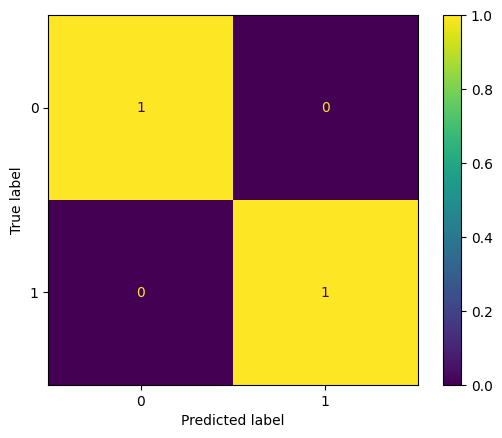

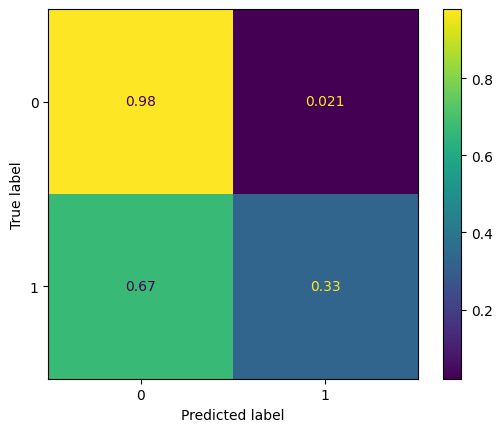

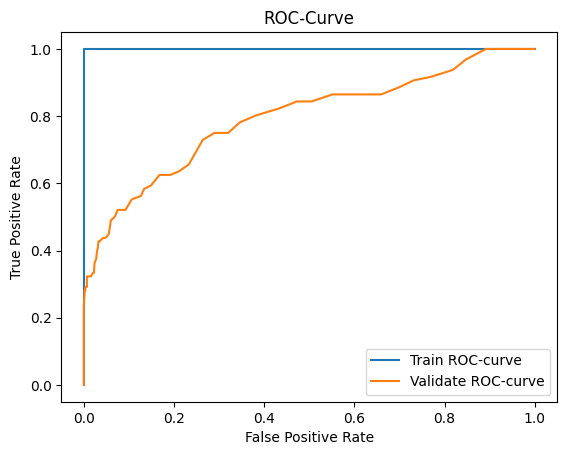

,accuracy,precision,recall,f1-score,roc-auc
Random Forest,0.888235,0.727273,0.333333,0.457143,0.793914


In [9]:
random_forest(rf)

The model perform really well on the training set, however it doesn't perform as effective to the validation set. There were a drop in all performance metrics suggesting that there might be an overfitting to the training data. We'll try to do the hyperparameter tuning to see if we can address this issues.

### Reduce Overfitting with n_estimators

default = 100

In [10]:
n_estimators = [2, 5, 10, 20, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

In [11]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in n_estimators:
    rf = RandomForestClassifier(random_state=8, n_estimators=i).fit(X_train, y_train)
    y_train_preds = rf.predict(X_train)
    y_val_preds = rf.predict(X_val)
    
    y_train_probs = rf.predict_proba(X_train)[:, 1]
    y_val_probs = rf.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_n_estimators = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=n_estimators)

tune_n_estimators

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
2,0.951027,0.858824,0.992527,0.500000,0.908896,0.239583,0.948873,0.323944,0.986480,0.603435
5,0.993798,0.851471,0.991905,0.469136,0.995723,0.395833,0.993810,0.429379,0.999392,0.725198
10,0.998075,0.888235,0.998715,0.700000,0.997434,0.364583,0.998074,0.479452,0.999986,0.769531
20,0.999358,0.888235,0.999572,0.717391,0.999145,0.343750,0.999358,0.464789,0.999999,0.809869
50,1.000000,0.894118,1.000000,0.772727,1.000000,0.354167,1.000000,0.485714,1.000000,0.808576
100,1.000000,0.888235,1.000000,0.727273,1.000000,0.333333,1.000000,0.457143,1.000000,0.793914
150,1.000000,0.888235,1.000000,0.738095,1.000000,0.322917,1.000000,0.449275,1.000000,0.794529
200,1.000000,0.889706,1.000000,0.756098,1.000000,0.322917,1.000000,0.452555,1.000000,0.800309
250,1.000000,0.892647,1.000000,0.767442,1.000000,0.343750,1.000000,0.474820,1.000000,0.801174
300,1.000000,0.889706,1.000000,0.756098,1.000000,0.322917,1.000000,0.452555,1.000000,0.809976


In [12]:
def plot_performance(parameter, xlabel):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(16, 5))
    
    ax1.plot(parameter, train_accuracy, label='train accuracy')
    ax1.plot(parameter, val_accuracy, label='val accuracy')
    ax1.legend()
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('accuracy')
    ax1.set_title('Accuracy Score')
    
    ax2.plot(parameter, train_precision, label='train precision')
    ax2.plot(parameter, val_precision, label='val precision')
    ax2.legend()
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel('precision')
    ax2.set_title('Precision Score')
    
    ax3.plot(parameter, train_recall, label='train recall')
    ax3.plot(parameter, val_recall, label='val recall')
    ax3.legend()
    ax3.set_xlabel(xlabel)
    ax3.set_ylabel('recall')
    ax3.set_title('Recall Score')
    
    ax4.plot(parameter, train_f1, label='train f1')
    ax4.plot(parameter, val_f1, label='val f1')
    ax4.legend()
    ax4.set_xlabel(xlabel)
    ax4.set_ylabel('f1')
    ax4.set_title('F1-Score')
    
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)
    
    ax5.plot(fpr_train, tpr_train, label='train roc-auc')
    ax5.plot(fpr_val, tpr_val, label='val roc-auc')
    ax5.legend()
    ax5.set_xlabel('false positive rate')
    ax5.set_ylabel('true positive rate')
    ax5.set_title('ROC-AUC Score')
    
    plt.subplots_adjust(wspace=0.4)
    plt.show()    

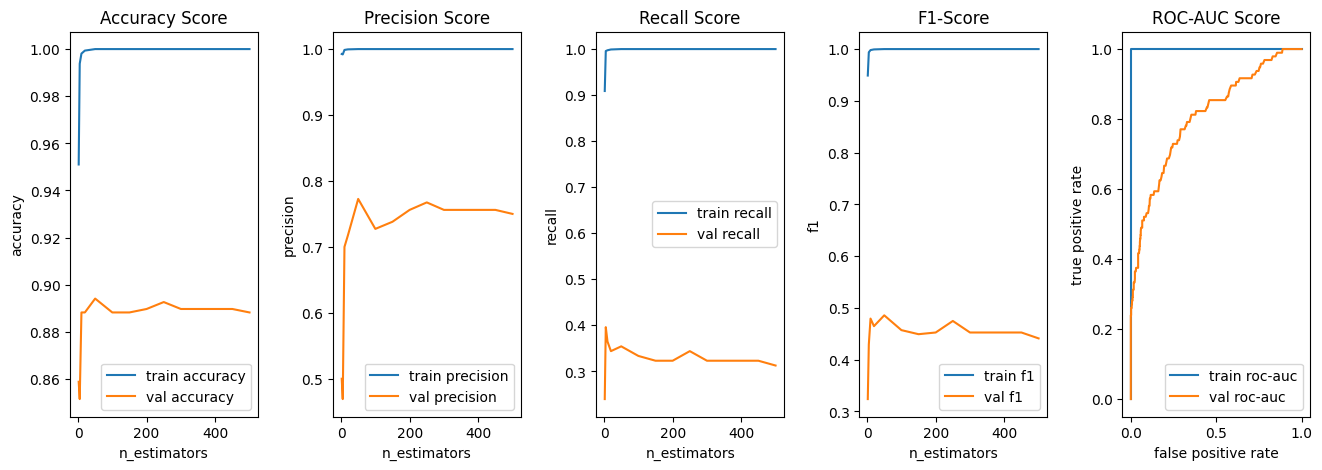

In [13]:
plot_performance(n_estimators, 'n_estimators')

### Reduce Overfitting with max_depth

default = None

In [14]:
max_depth = [2, 5, 10, 20, 50, 100, 150, 200, None]

In [15]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in max_depth:
    rf = RandomForestClassifier(random_state=8, n_estimators=50, max_depth=i).fit(X_train, y_train)
    y_train_preds = rf.predict(X_train)
    y_val_preds = rf.predict(X_val)
    
    y_train_probs = rf.predict_proba(X_train)[:, 1]
    y_val_probs = rf.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_max_depth = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=max_depth)

tune_max_depth

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
2.0,0.743584,0.826471,0.884537,0.362500,0.560308,0.302083,0.686043,0.329545,0.854295,0.735864
5.0,0.844311,0.867647,0.931404,0.539474,0.743370,0.427083,0.826832,0.476744,0.936524,0.784978
10.0,0.977759,0.880882,0.986498,0.622951,0.968777,0.395833,0.977557,0.484076,0.998023,0.810449
20.0,1.000000,0.892647,1.000000,0.780488,1.000000,0.333333,1.000000,0.467153,1.000000,0.801887
50.0,1.000000,0.894118,1.000000,0.772727,1.000000,0.354167,1.000000,0.485714,1.000000,0.808576
100.0,1.000000,0.894118,1.000000,0.772727,1.000000,0.354167,1.000000,0.485714,1.000000,0.808576
150.0,1.000000,0.894118,1.000000,0.772727,1.000000,0.354167,1.000000,0.485714,1.000000,0.808576
200.0,1.000000,0.894118,1.000000,0.772727,1.000000,0.354167,1.000000,0.485714,1.000000,0.808576
NaN,1.000000,0.894118,1.000000,0.772727,1.000000,0.354167,1.000000,0.485714,1.000000,0.808576


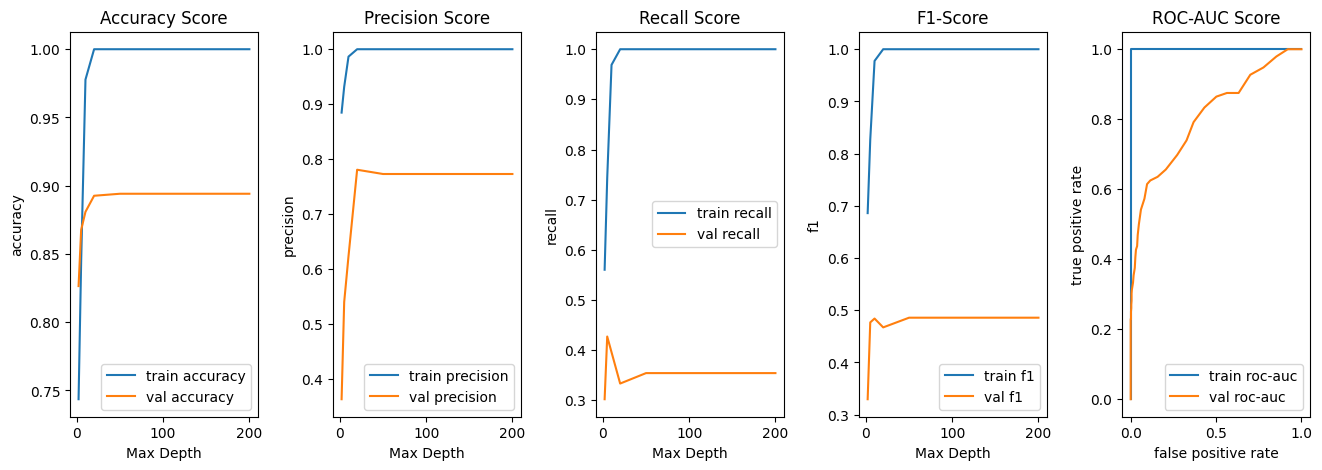

In [16]:
plot_performance(max_depth, 'Max Depth')

#### max_depth = 5

In [17]:
rf_max_depth = RandomForestClassifier(random_state=8, n_estimators=50, max_depth=5)
rf_max_depth.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=50, random_state=8)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    0.844311   0.931404  0.743370  0.826832  0.936524
Validation Set  0.867647   0.539474  0.427083  0.476744  0.784978


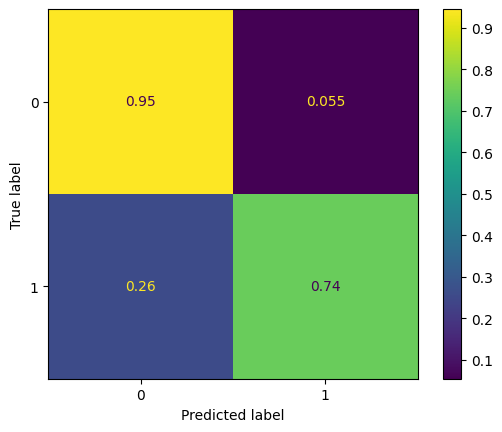

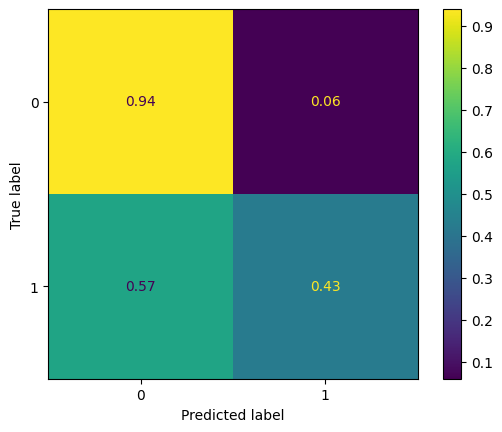

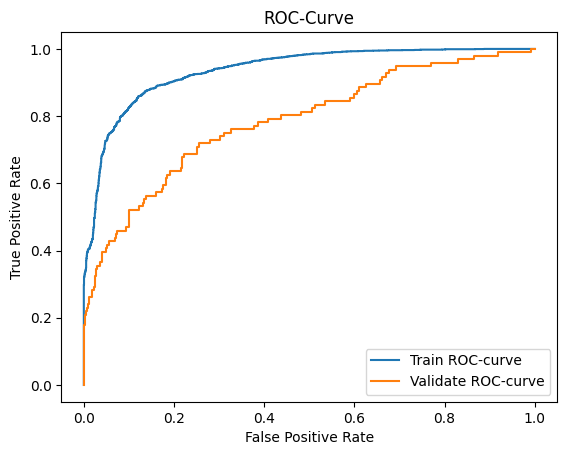

,accuracy,precision,recall,f1-score,roc-auc
Random Forest,0.867647,0.539474,0.427083,0.476744,0.784978


In [18]:
random_forest(rf_max_depth)

### Reduce Overfitting with min samples split

default = 2

In [19]:
min_samples_split = [2, 5, 10, 20, 50, 100, 150, 200]

In [20]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in min_samples_split:
    rf = RandomForestClassifier(random_state=8, n_estimators=50, max_depth=5, min_samples_split=i).fit(X_train, y_train)
    y_train_preds = rf.predict(X_train)
    y_val_preds = rf.predict(X_val)
    
    y_train_probs = rf.predict_proba(X_train)[:, 1]
    y_val_probs = rf.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_min_samples_split = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=min_samples_split)

tune_min_samples_split

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
2,0.844311,0.867647,0.931404,0.539474,0.743370,0.427083,0.826832,0.476744,0.936524,0.784978
5,0.846236,0.861765,0.927177,0.512500,0.751497,0.427083,0.830144,0.465909,0.935644,0.785031
10,0.841959,0.860294,0.926400,0.506494,0.742943,0.406250,0.824591,0.450867,0.934758,0.776425
20,0.842814,0.850000,0.919414,0.465116,0.751497,0.416667,0.827018,0.439560,0.933009,0.792059
50,0.844311,0.860294,0.912398,0.506024,0.761762,0.437500,0.830303,0.469274,0.928967,0.784282
100,0.840462,0.864706,0.918947,0.525641,0.746792,0.427083,0.823974,0.471264,0.931432,0.785674
150,0.834046,0.852941,0.918094,0.474359,0.733533,0.385417,0.815502,0.425287,0.928209,0.783943
200,0.835971,0.850000,0.905106,0.465116,0.750642,0.416667,0.820669,0.439560,0.920560,0.780322


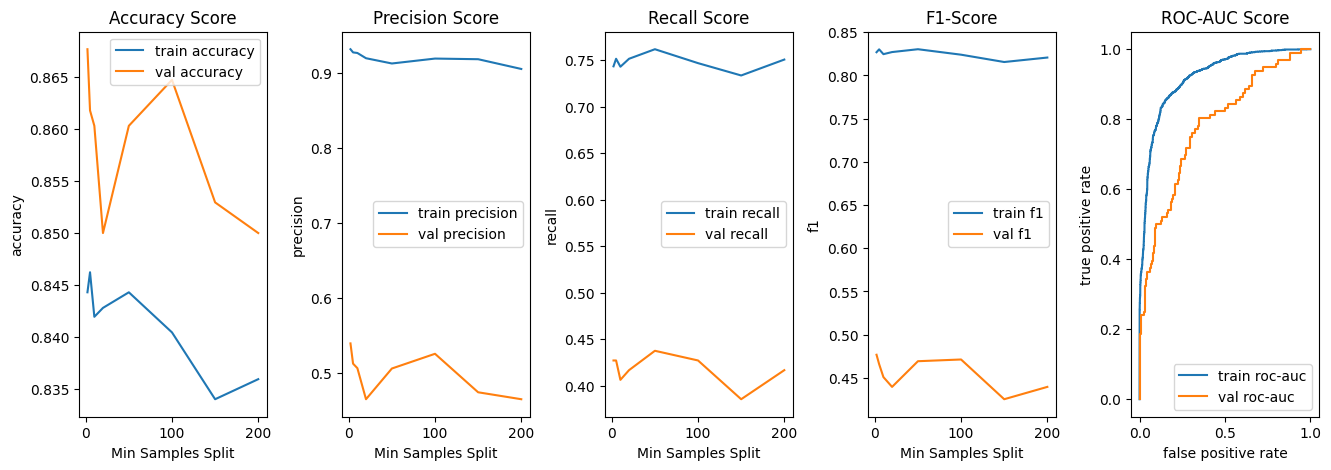

In [21]:
plot_performance(min_samples_split, 'Min Samples Split')

#### min_samples_split = 50

In [22]:
rf_min_samples_split = RandomForestClassifier(random_state=8, n_estimators=50, max_depth=5, min_samples_split=50)
rf_min_samples_split.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_split=50, n_estimators=50,
                       random_state=8)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    0.844311   0.912398  0.761762  0.830303  0.928967
Validation Set  0.860294   0.506024  0.437500  0.469274  0.784282


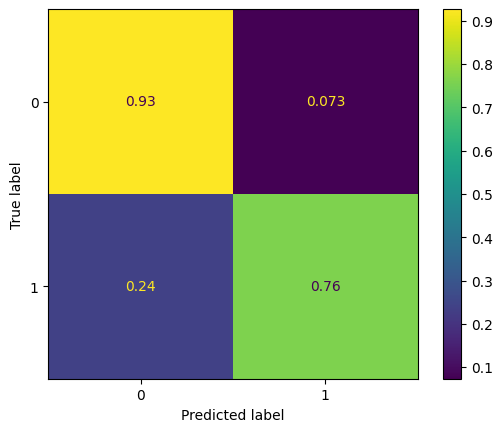

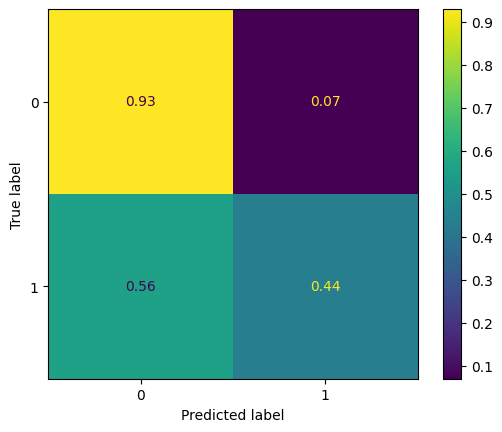

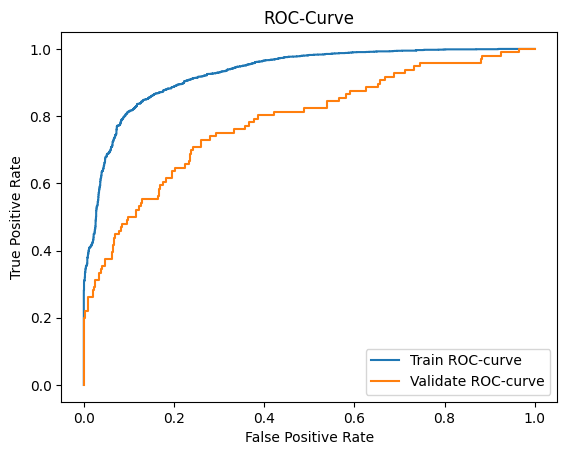

,accuracy,precision,recall,f1-score,roc-auc
Random Forest,0.860294,0.506024,0.4375,0.469274,0.784282


In [23]:
random_forest(rf_min_samples_split)

### Reduce Overfitting with min samples leaf

default = 1

In [24]:
min_samples_leaf = [1, 2, 5, 10, 15, 20, 50, 100, 150 ,200]

In [25]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in min_samples_leaf:
    rf = RandomForestClassifier(random_state=8, n_estimators=50, max_depth=5, min_samples_split=50, min_samples_leaf=i).fit(X_train, y_train)
    y_train_preds = rf.predict(X_train)
    y_val_preds = rf.predict(X_val)
    
    y_train_probs = rf.predict_proba(X_train)[:, 1]
    y_val_probs = rf.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_min_samples_leaf = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=min_samples_leaf)

tune_min_samples_leaf

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
1,0.844311,0.860294,0.912398,0.506024,0.761762,0.437500,0.830303,0.469274,0.928967,0.784282
2,0.846022,0.861765,0.913177,0.511905,0.764756,0.447917,0.832402,0.477778,0.928889,0.783604
5,0.842814,0.858824,0.909974,0.500000,0.760907,0.447917,0.828791,0.472527,0.927711,0.781518
10,0.841531,0.861765,0.911386,0.512195,0.756630,0.437500,0.826829,0.471910,0.928862,0.781874
15,0.834260,0.858824,0.908094,0.500000,0.743798,0.437500,0.817776,0.466667,0.927894,0.780608
20,0.833618,0.857353,0.907950,0.493976,0.742515,0.427083,0.816941,0.458101,0.927430,0.780768
50,0.836399,0.854412,0.912861,0.482353,0.743798,0.427083,0.819703,0.453039,0.924703,0.768122
100,0.821001,0.816176,0.882323,0.359223,0.740804,0.385417,0.805394,0.371859,0.905760,0.760310
150,0.810950,0.814706,0.864594,0.375000,0.737382,0.468750,0.795937,0.416667,0.892961,0.766820
200,0.797690,0.810294,0.873391,0.336634,0.696322,0.354167,0.774869,0.345178,0.890610,0.767534


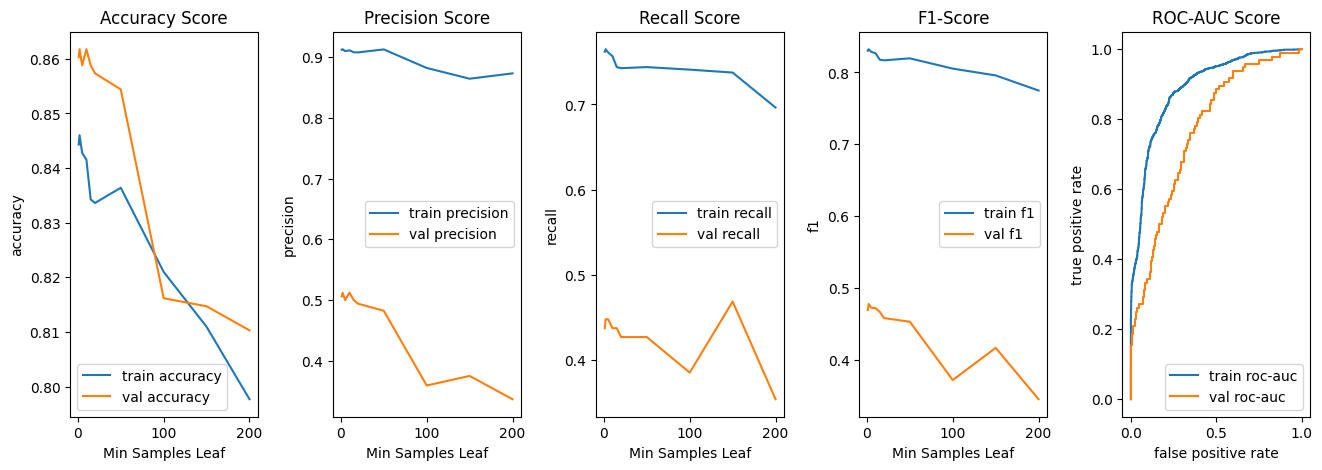

In [26]:
plot_performance(min_samples_leaf, 'Min Samples Leaf')

#### min_samples_leaf = 50

In [27]:
rf_min_samples_leaf = RandomForestClassifier(random_state=8, n_estimators=50, max_depth=5, min_samples_split=50, min_samples_leaf=2)
rf_min_samples_leaf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=50,
                       n_estimators=50, random_state=8)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    0.846022   0.913177  0.764756  0.832402  0.928889
Validation Set  0.861765   0.511905  0.447917  0.477778  0.783604


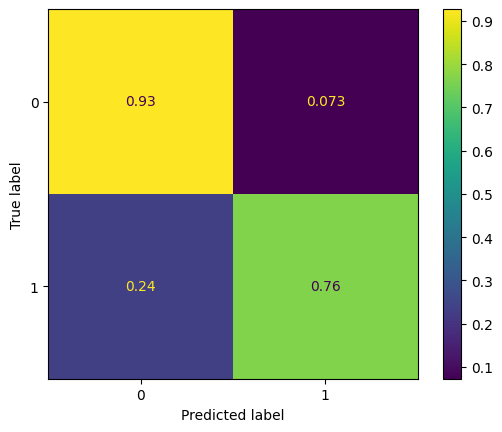

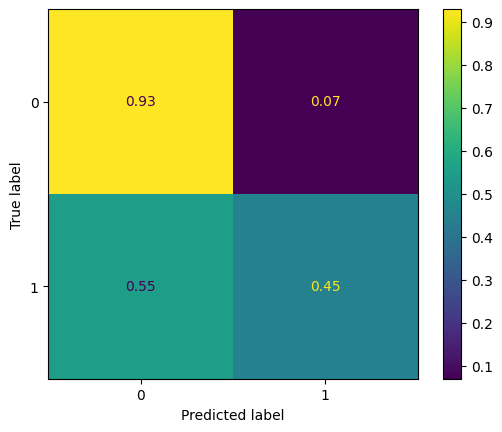

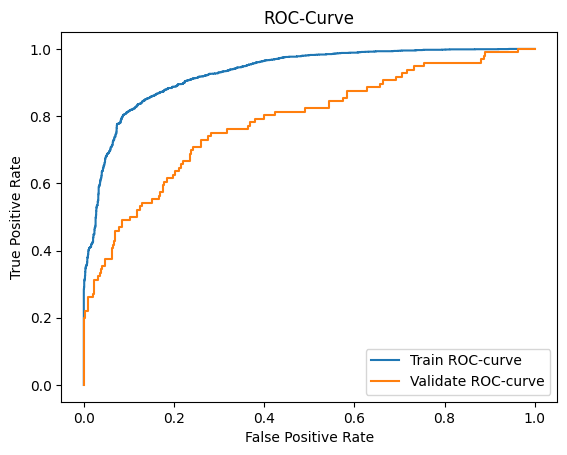

,accuracy,precision,recall,f1-score,roc-auc
Random Forest,0.861765,0.511905,0.447917,0.477778,0.783604


In [28]:
random_forest(rf_min_samples_leaf)

### Reduce Overfitting with max_features

default = sqrt

In [29]:
max_features = ['auto', 'sqrt', 'log2', None]

In [30]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in max_features:
    rf = RandomForestClassifier(random_state=8, n_estimators=50, max_depth=5, min_samples_split=50, min_samples_leaf=2, max_features=i).fit(X_train, y_train)
    y_train_preds = rf.predict(X_train)
    y_val_preds = rf.predict(X_val)
    
    y_train_probs = rf.predict_proba(X_train)[:, 1]
    y_val_probs = rf.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_max_features = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=max_features)

tune_max_features

/Users/narongvatchingpayakmon/Projects/internship_c/internship_c_dataset_1/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
auto,0.846022,0.861765,0.913177,0.511905,0.764756,0.447917,0.832402,0.477778,0.928889,0.783604
sqrt,0.846022,0.861765,0.913177,0.511905,0.764756,0.447917,0.832402,0.477778,0.928889,0.783604
log2,0.857571,0.857353,0.916335,0.493671,0.786997,0.406250,0.846756,0.445714,0.931271,0.777683
None,0.798332,0.875000,0.956181,0.634146,0.625321,0.270833,0.756142,0.379562,0.900473,0.782008


### Reduce Overfitting with criterion

default = gini

In [31]:
criterion = ['gini', 'entropy', 'log_loss']

In [32]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in criterion:
    rf = RandomForestClassifier(random_state=8, n_estimators=50, max_depth=5, min_samples_split=50, min_samples_leaf=2, max_features='sqrt', criterion=i).fit(X_train, y_train)
    y_train_preds = rf.predict(X_train)
    y_val_preds = rf.predict(X_val)
    
    y_train_probs = rf.predict_proba(X_train)[:, 1]
    y_val_probs = rf.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_criterion = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=criterion)

tune_criterion

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
gini,0.846022,0.861765,0.913177,0.511905,0.764756,0.447917,0.832402,0.477778,0.928889,0.783604
entropy,0.839607,0.864706,0.923693,0.526316,0.740376,0.416667,0.821937,0.465116,0.925671,0.772885
log_loss,0.839607,0.864706,0.923693,0.526316,0.740376,0.416667,0.821937,0.465116,0.925671,0.772885


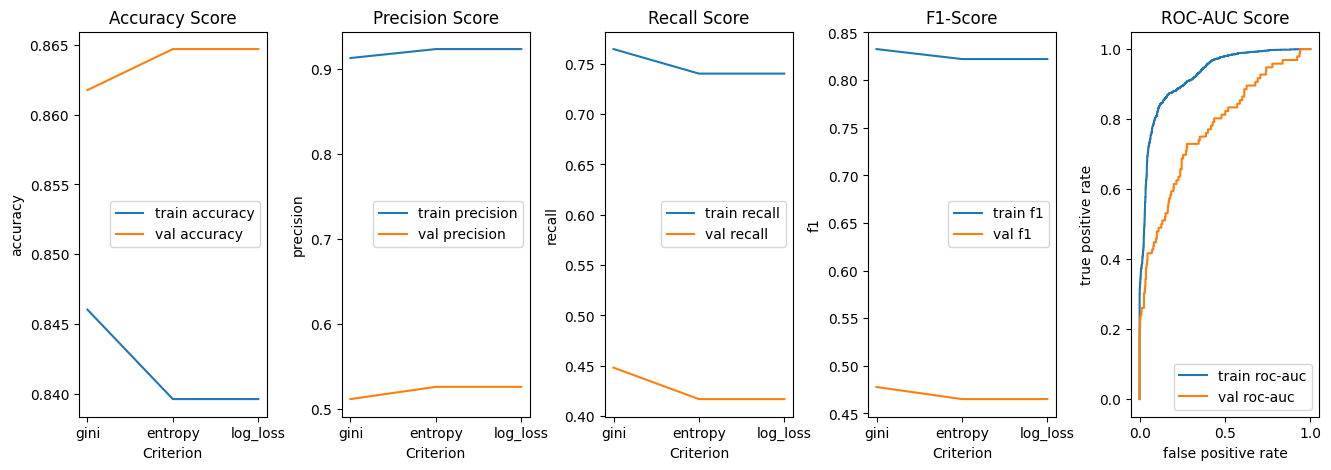

In [33]:
plot_performance(criterion, 'Criterion')

#### criterion = 'gini'

In [34]:
rf_criterion = RandomForestClassifier(random_state=8, n_estimators=50, max_depth=5, min_samples_split=50, min_samples_leaf=2, max_features='sqrt', criterion='gini')
rf_criterion.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=50,
                       n_estimators=50, random_state=8)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    0.846022   0.913177  0.764756  0.832402  0.928889
Validation Set  0.861765   0.511905  0.447917  0.477778  0.783604


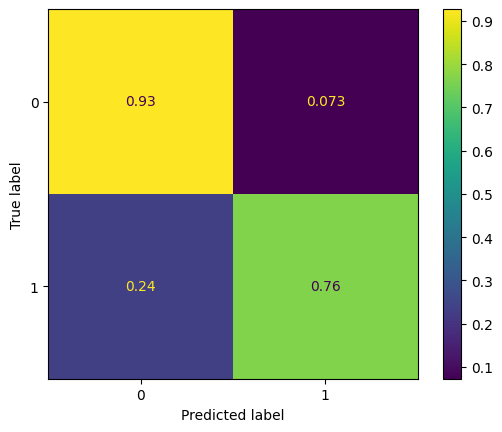

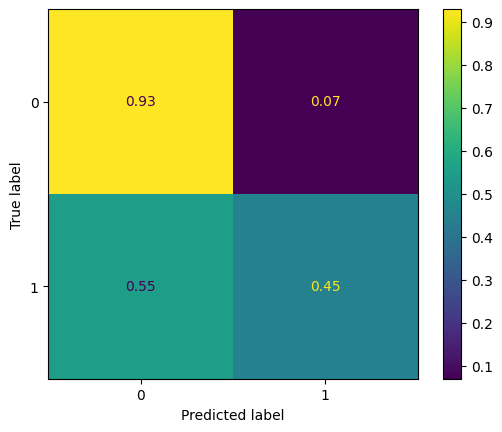

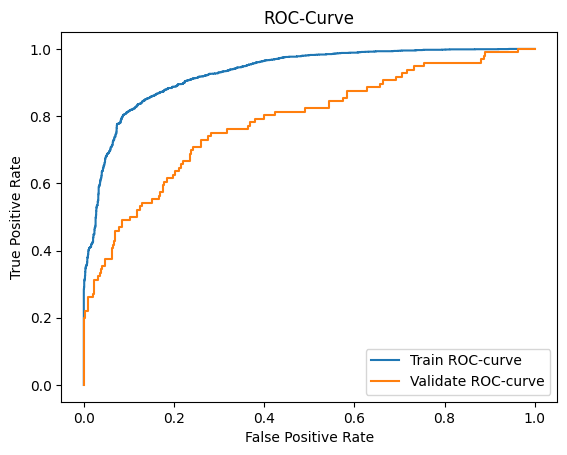

,accuracy,precision,recall,f1-score,roc-auc
Random Forest,0.861765,0.511905,0.447917,0.477778,0.783604


In [35]:
random_forest(rf_criterion)

### Reduce overfitting with Max Samples

In [36]:
max_samples = [0.5, 0.8, 1.0]

In [37]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in max_samples:
    rf = RandomForestClassifier(random_state=8, n_estimators=50, max_depth=5, min_samples_split=50, min_samples_leaf=2, max_features='sqrt', criterion='gini', max_samples=i).fit(X_train, y_train)
    y_train_preds = rf.predict(X_train)
    y_val_preds = rf.predict(X_val)
    
    y_train_probs = rf.predict_proba(X_train)[:, 1]
    y_val_probs = rf.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_max_samples = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=max_samples)

tune_max_samples

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
0.5,0.829769,0.861765,0.923626,0.513158,0.718991,0.406250,0.808562,0.453488,0.927451,0.775917
0.8,0.835543,0.851471,0.913548,0.470588,0.741232,0.416667,0.818418,0.441989,0.931563,0.776345
1.0,0.846022,0.861765,0.913177,0.511905,0.764756,0.447917,0.832402,0.477778,0.928889,0.783604


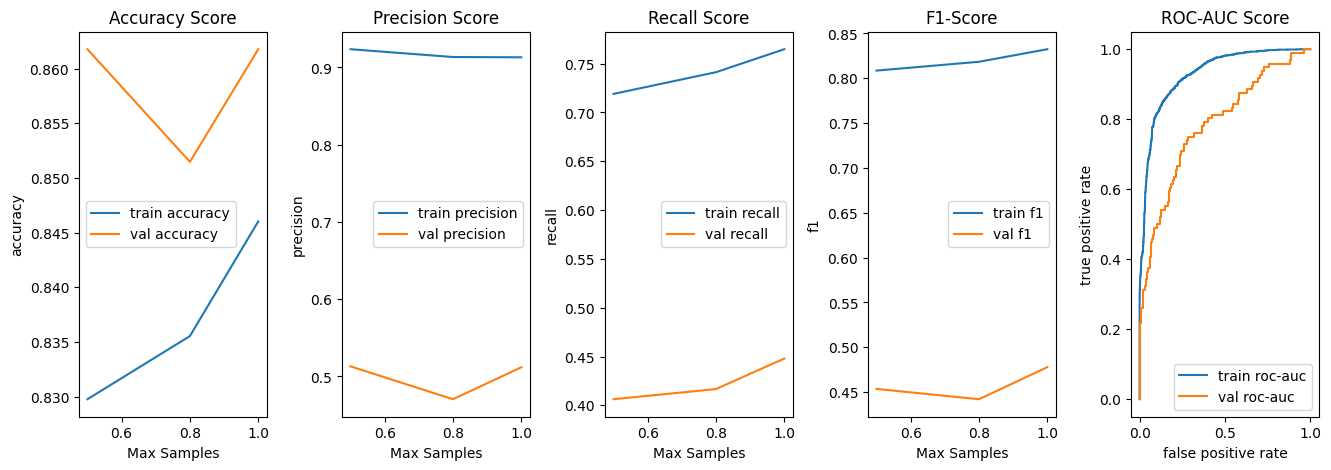

In [38]:
plot_performance(max_samples, 'Max Samples')

### Model After Hyperparameter Tuning

In [39]:
rf_tune = RandomForestClassifier(random_state=8, n_estimators=50, max_depth=5, min_samples_split=50, min_samples_leaf=2, max_features='sqrt', criterion='gini', max_samples=i)
rf_tune.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_samples=1.0, min_samples_leaf=2,
                       min_samples_split=50, n_estimators=50, random_state=8)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    0.846022   0.913177  0.764756  0.832402  0.928889
Validation Set  0.861765   0.511905  0.447917  0.477778  0.783604


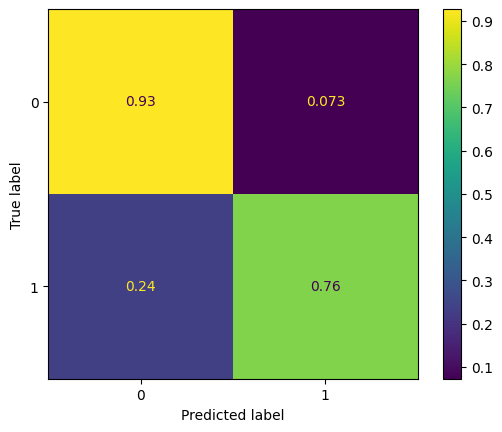

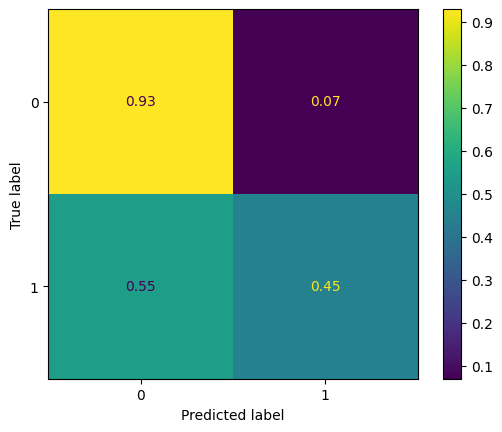

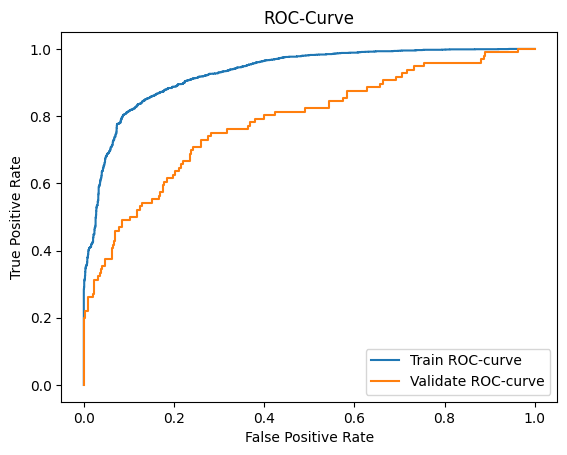

In [40]:
rf_smote = random_forest(rf_tune)

In [41]:
dump(rf_tune, '../models/random_forest_smote.joblib')

['../models/random_forest_smote.joblib']

**True Positive**: Correctly predicted "churn"

**True Negative**: Correctly predicted "not churn"

**False Positive**: Predicted "churn", but actually "not churn"

**False Negative**: Predicted "not churn", but actually "churn"



- For churn prediction, we'll prioritize recall over precision since False Negative are more costly than False Positive.

- The high False Negative (61%) in the validation set suggest that the model might not be able to capture the actual churn customers and predicted as not churn.

In [42]:
rf_smote.to_csv('../data/processed/model/4_rf_smote.csv', index=False)

### Without SMOTE (use class_weight = 'balanced')

In [43]:
X_train = pd.read_csv('../data/processed/X_train.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')
X_val = pd.read_csv('../data/processed/X_val.csv')
y_val = pd.read_csv('../data/processed/y_val.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

In [44]:
y_train = y_train.values.ravel()
y_val = y_val.values.ravel()
y_test = y_test.values.ravel()

In [45]:
rf = RandomForestClassifier(random_state=8, class_weight='balanced')
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=8)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    1.000000   1.000000  1.000000  1.000000  1.000000
Validation Set  0.916176   0.953488  0.427083  0.589928  0.777736


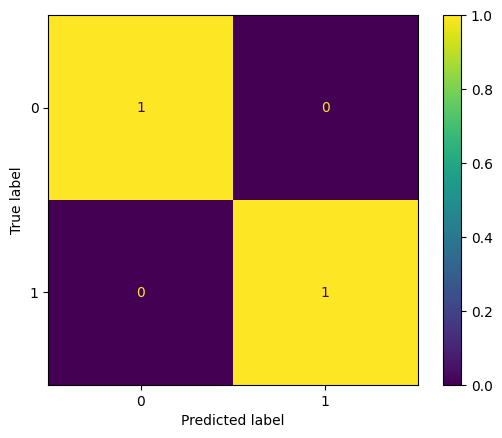

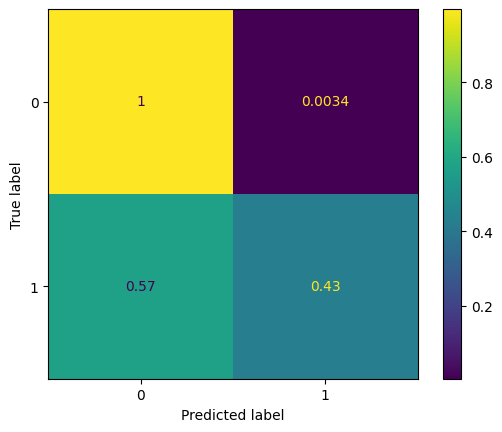

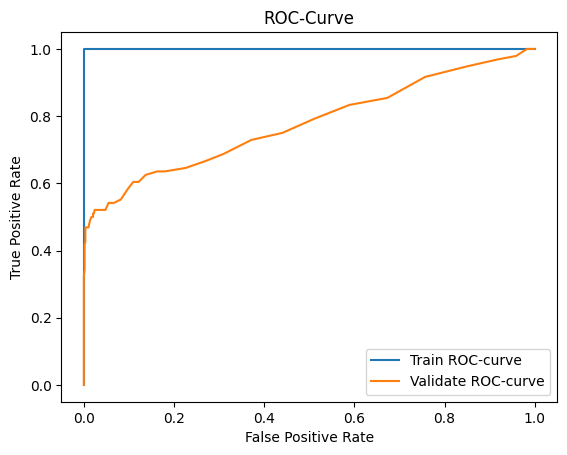

,accuracy,precision,recall,f1-score,roc-auc
Random Forest,0.916176,0.953488,0.427083,0.589928,0.777736


In [46]:
random_forest(rf)

### Reduce Overfitting with n_estimators

default = 100

In [47]:
n_estimators = [2, 5, 10, 20, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

In [48]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in n_estimators:
    rf = RandomForestClassifier(random_state=8, class_weight='balanced', n_estimators=i).fit(X_train, y_train)
    y_train_preds = rf.predict(X_train)
    y_val_preds = rf.predict(X_val)
    
    y_train_probs = rf.predict_proba(X_train)[:, 1]
    y_val_probs = rf.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_n_estimators = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=n_estimators)

tune_n_estimators

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
2,0.943382,0.888235,0.983051,0.794118,0.607330,0.281250,0.750809,0.415385,0.960630,0.702973
5,0.984559,0.902941,0.988506,0.800000,0.900524,0.416667,0.942466,0.547945,0.996986,0.764055
10,0.987868,0.898529,1.000000,0.885714,0.913613,0.322917,0.954856,0.473282,0.999855,0.792451
20,0.994853,0.908824,1.000000,0.972222,0.963351,0.364583,0.981333,0.530303,1.000000,0.794012
50,0.999632,0.914706,1.000000,0.975000,0.997382,0.406250,0.998689,0.573529,1.000000,0.773660
100,1.000000,0.916176,1.000000,0.953488,1.000000,0.427083,1.000000,0.589928,1.000000,0.777736
150,1.000000,0.913235,1.000000,0.951220,1.000000,0.406250,1.000000,0.569343,1.000000,0.790926
200,1.000000,0.914706,1.000000,0.952381,1.000000,0.416667,1.000000,0.579710,1.000000,0.788697
250,1.000000,0.914706,1.000000,0.952381,1.000000,0.416667,1.000000,0.579710,1.000000,0.799461
300,1.000000,0.914706,1.000000,0.952381,1.000000,0.416667,1.000000,0.579710,1.000000,0.799970


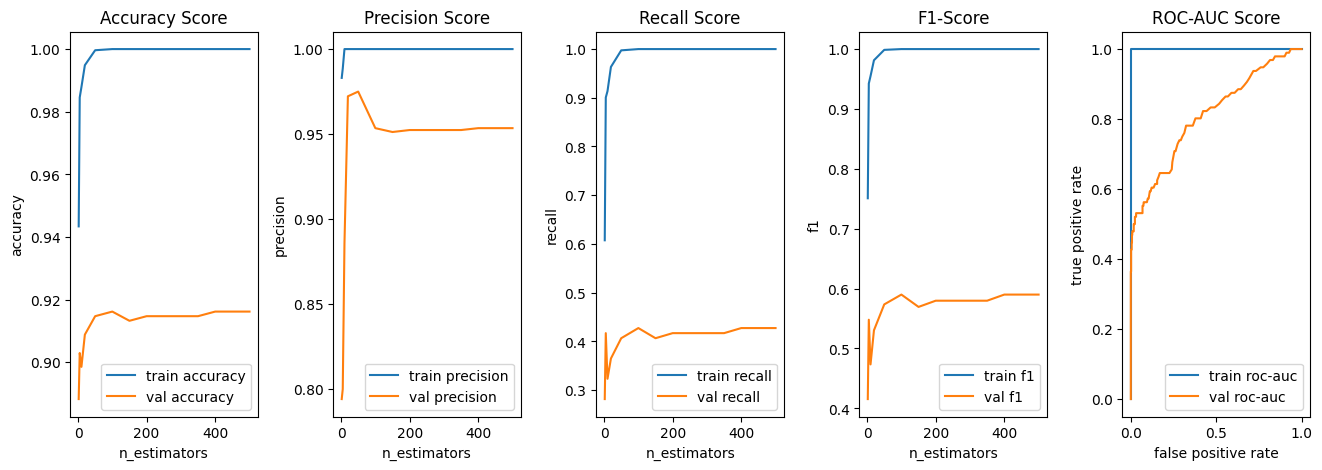

In [49]:
plot_performance(n_estimators, 'n_estimators')

### Reduce Overfitting with max_depth

default = None

In [50]:
max_depth = [2, 5, 10, 20, 50, 100, 150, 200, None]

In [51]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in max_depth:
    rf = RandomForestClassifier(random_state=8, class_weight='balanced', n_estimators=500, max_depth=i).fit(X_train, y_train)
    y_train_preds = rf.predict(X_train)
    y_val_preds = rf.predict(X_val)
    
    y_train_probs = rf.predict_proba(X_train)[:, 1]
    y_val_probs = rf.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_max_depth = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=max_depth)

tune_max_depth

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
2.0,0.858456,0.839706,0.496659,0.438095,0.583770,0.479167,0.536703,0.457711,0.804593,0.747378
5.0,0.913235,0.889706,0.717262,0.643836,0.630890,0.489583,0.671309,0.556213,0.923811,0.817013
10.0,0.979412,0.916176,0.993939,0.933333,0.858639,0.437500,0.921348,0.595745,0.999578,0.849190
20.0,1.000000,0.914706,1.000000,0.931818,1.000000,0.427083,1.000000,0.585714,1.000000,0.813535
50.0,1.000000,0.916176,1.000000,0.953488,1.000000,0.427083,1.000000,0.589928,1.000000,0.810698
100.0,1.000000,0.916176,1.000000,0.953488,1.000000,0.427083,1.000000,0.589928,1.000000,0.810698
150.0,1.000000,0.916176,1.000000,0.953488,1.000000,0.427083,1.000000,0.589928,1.000000,0.810698
200.0,1.000000,0.916176,1.000000,0.953488,1.000000,0.427083,1.000000,0.589928,1.000000,0.810698
NaN,1.000000,0.916176,1.000000,0.953488,1.000000,0.427083,1.000000,0.589928,1.000000,0.810698


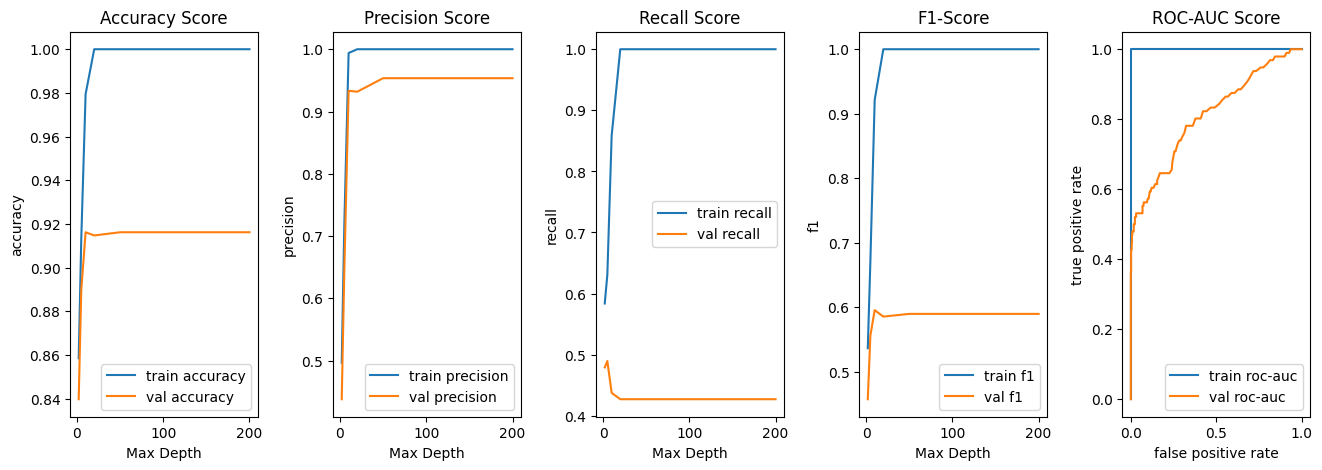

In [52]:
plot_performance(max_depth, 'Max Depth')

#### max_depth = 5

In [53]:
rf_max_depth = RandomForestClassifier(random_state=8, class_weight='balanced', n_estimators=500, max_depth=5)
rf_max_depth.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=500,
                       random_state=8)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    0.913235   0.717262  0.630890  0.671309  0.923811
Validation Set  0.889706   0.643836  0.489583  0.556213  0.817013


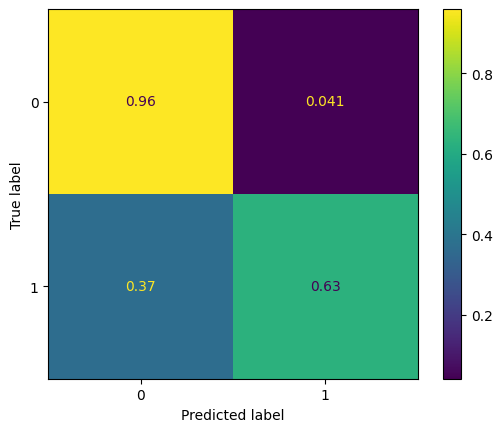

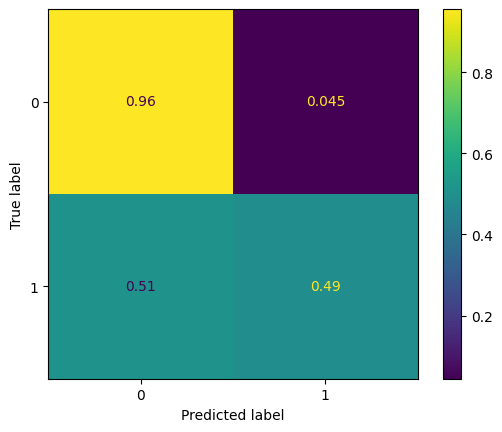

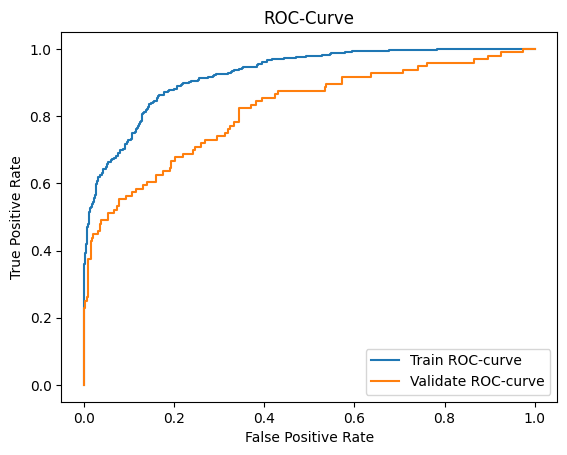

,accuracy,precision,recall,f1-score,roc-auc
Random Forest,0.889706,0.643836,0.489583,0.556213,0.817013


In [54]:
random_forest(rf_max_depth)

### Reduce Overfitting with min samples split

default = 2

In [55]:
min_samples_split = [2, 5, 10, 20, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

In [56]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in min_samples_split:
    rf = RandomForestClassifier(random_state=8, class_weight='balanced', n_estimators=500, max_depth=5, min_samples_split=i).fit(X_train, y_train)
    y_train_preds = rf.predict(X_train)
    y_val_preds = rf.predict(X_val)
    
    y_train_probs = rf.predict_proba(X_train)[:, 1]
    y_val_probs = rf.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_min_samples_split = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=min_samples_split)

tune_min_samples_split

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
2,0.913235,0.889706,0.717262,0.643836,0.630890,0.489583,0.671309,0.556213,0.923811,0.817013
5,0.912868,0.888235,0.715134,0.635135,0.630890,0.489583,0.670376,0.552941,0.924058,0.816442
10,0.912132,0.889706,0.709677,0.640000,0.633508,0.500000,0.669433,0.561404,0.922074,0.817173
20,0.910294,0.888235,0.701754,0.631579,0.628272,0.500000,0.662983,0.558140,0.917651,0.812964
50,0.898897,0.866176,0.644986,0.528090,0.623037,0.489583,0.633822,0.508108,0.904012,0.801816
100,0.876838,0.847059,0.554524,0.462264,0.625654,0.510417,0.587946,0.485149,0.889032,0.796251
150,0.841912,0.822059,0.454023,0.398374,0.620419,0.510417,0.524336,0.447489,0.873535,0.787314
200,0.834559,0.820588,0.437729,0.395161,0.625654,0.510417,0.515086,0.445455,0.860184,0.777433
250,0.831618,0.819118,0.431655,0.392000,0.628272,0.510417,0.511727,0.443439,0.850493,0.768229
300,0.830882,0.819118,0.430108,0.392000,0.628272,0.510417,0.510638,0.443439,0.844596,0.760916


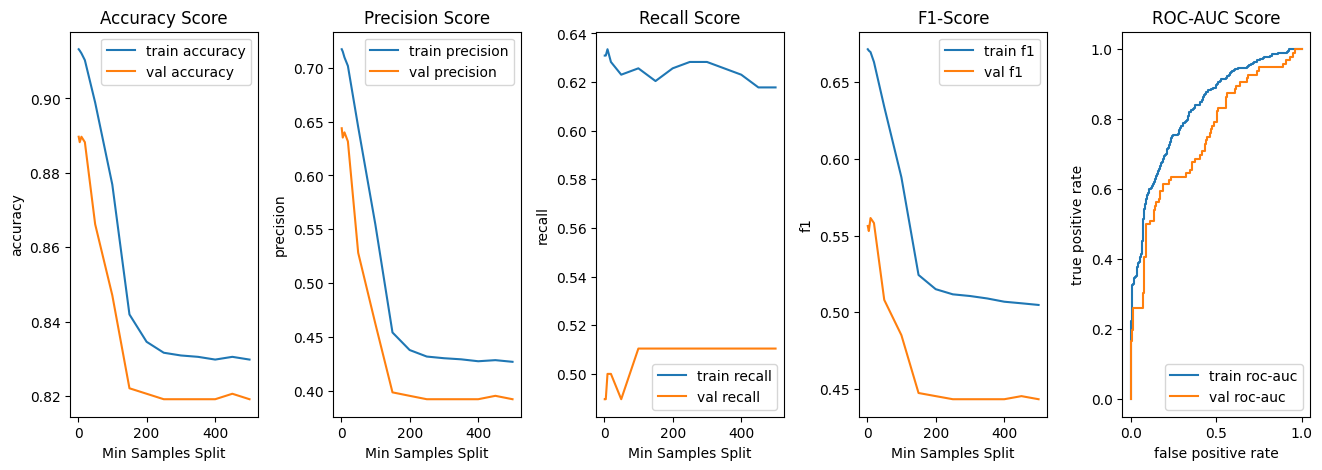

In [57]:
plot_performance(min_samples_split, 'Min Samples Split')

#### min_samples_split = 10

In [58]:
rf_min_samples_split = RandomForestClassifier(random_state=8, class_weight='balanced', n_estimators=500, max_depth=5, min_samples_split=10)
rf_min_samples_split.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_split=10, n_estimators=500, random_state=8)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    0.912132   0.709677  0.633508  0.669433  0.922074
Validation Set  0.889706   0.640000  0.500000  0.561404  0.817173


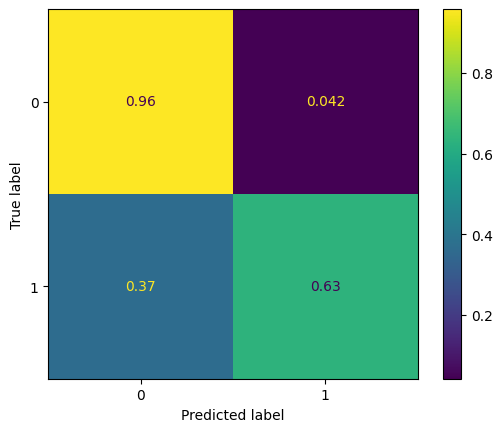

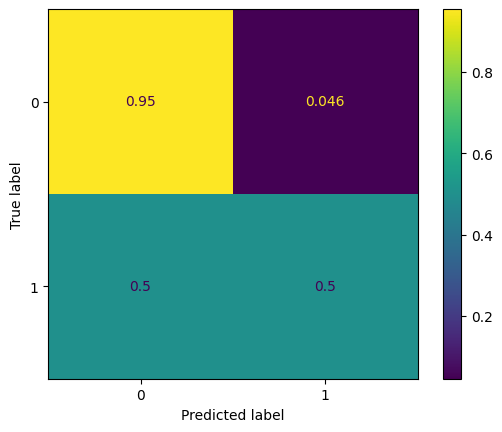

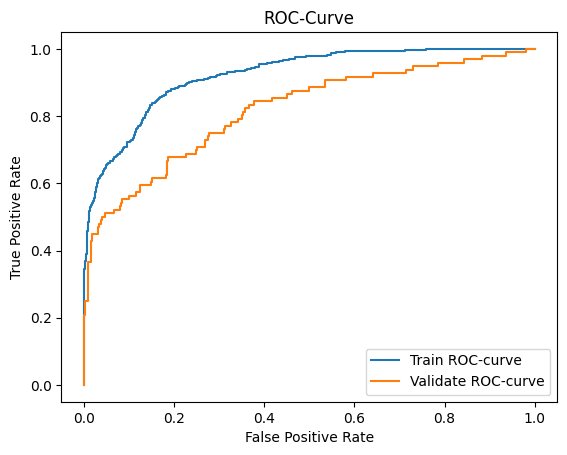

,accuracy,precision,recall,f1-score,roc-auc
Random Forest,0.889706,0.64,0.5,0.561404,0.817173


In [59]:
random_forest(rf_min_samples_split)

### Reduce Overfitting with min samples leaf

default = 1

In [60]:
min_samples_leaf = [1, 2, 5, 10, 15, 20, 50, 100, 150 ,200]

In [61]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in min_samples_leaf:
    rf = RandomForestClassifier(random_state=8, class_weight='balanced', n_estimators=500, max_depth=5, min_samples_split=10, min_samples_leaf=i).fit(X_train, y_train)
    y_train_preds = rf.predict(X_train)
    y_val_preds = rf.predict(X_val)
    
    y_train_probs = rf.predict_proba(X_train)[:, 1]
    y_val_probs = rf.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_min_samples_leaf = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=min_samples_leaf)

tune_min_samples_leaf

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
1,0.912132,0.889706,0.709677,0.640000,0.633508,0.500000,0.669433,0.561404,0.922074,0.817173
2,0.911765,0.892647,0.708824,0.657534,0.630890,0.500000,0.667590,0.568047,0.921693,0.815907
5,0.912500,0.891176,0.713018,0.648649,0.630890,0.500000,0.669444,0.564706,0.919163,0.812661
10,0.905515,0.875000,0.678063,0.566265,0.623037,0.489583,0.649386,0.525140,0.910224,0.806239
15,0.899265,0.866176,0.644385,0.527473,0.630890,0.500000,0.637566,0.513369,0.902669,0.803742
20,0.887500,0.855882,0.593596,0.489796,0.630890,0.500000,0.611675,0.494845,0.893438,0.795965
50,0.850000,0.827941,0.474308,0.413223,0.628272,0.520833,0.540541,0.460829,0.867911,0.770013
100,0.861029,0.839706,0.504237,0.441441,0.623037,0.510417,0.557377,0.473430,0.846974,0.758205
150,0.847794,0.826471,0.464126,0.390000,0.541885,0.406250,0.500000,0.397959,0.833236,0.738888
200,0.824632,0.797059,0.397408,0.309091,0.481675,0.354167,0.435503,0.330097,0.798551,0.701502


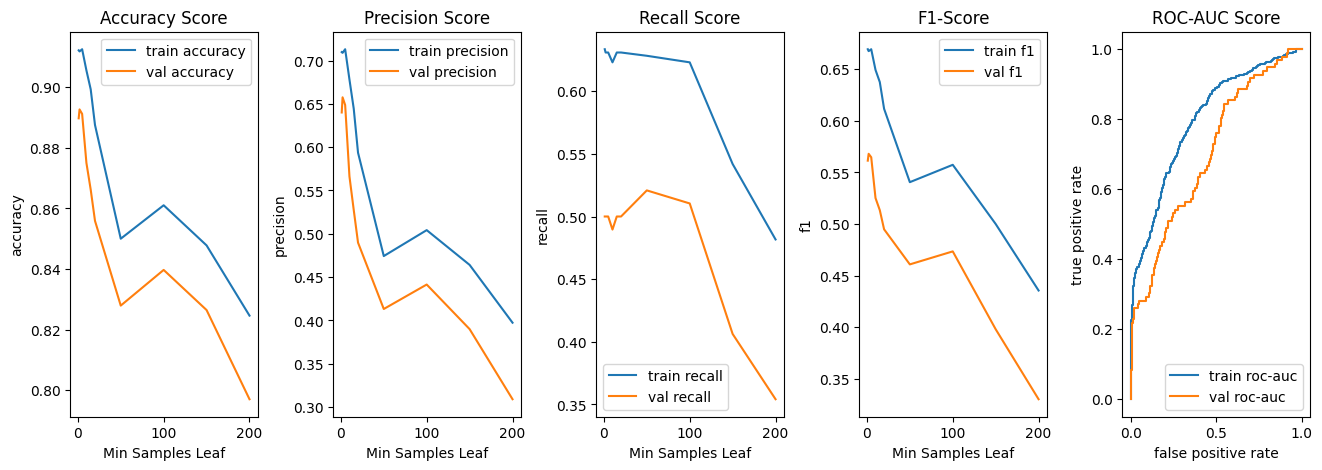

In [62]:
plot_performance(min_samples_leaf, 'Min Samples Leaf')

#### min_samples_leaf = 2

In [63]:
rf_min_samples_leaf = RandomForestClassifier(random_state=8, class_weight='balanced', n_estimators=500, max_depth=5, min_samples_split=10, min_samples_leaf=2)
rf_min_samples_leaf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=500, random_state=8)

                accuracy  precision   recall  f1-score   roc-auc
Training Set    0.911765   0.708824  0.63089  0.667590  0.921693
Validation Set  0.892647   0.657534  0.50000  0.568047  0.815907


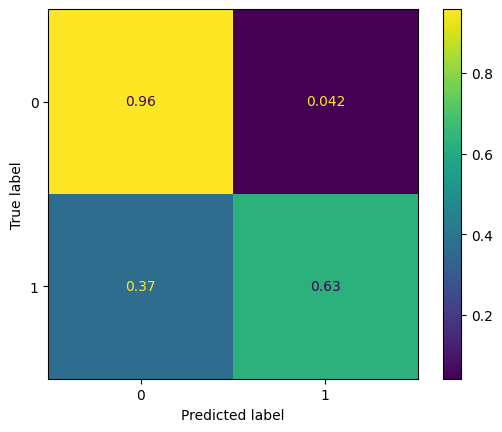

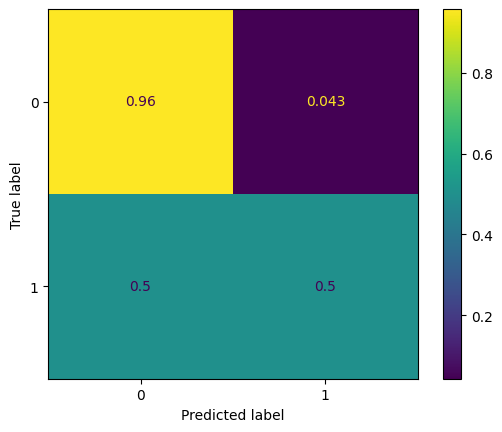

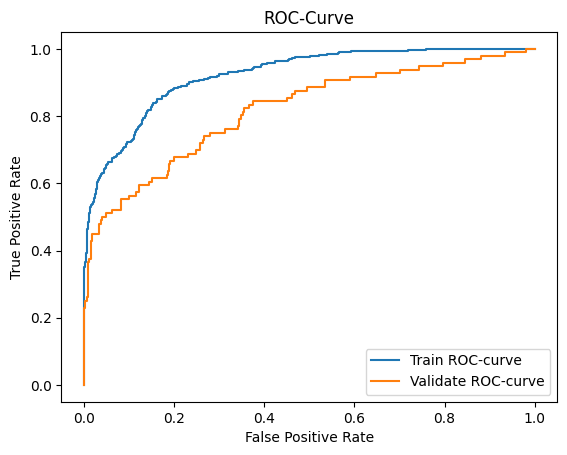

,accuracy,precision,recall,f1-score,roc-auc
Random Forest,0.892647,0.657534,0.5,0.568047,0.815907


In [64]:
random_forest(rf_min_samples_leaf)

### Reduce Overfitting with max_features

default = sqrt

In [65]:
max_features = ['auto', 'sqrt', 'log2', None]

In [66]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in max_features:
    rf = RandomForestClassifier(random_state=8, class_weight='balanced', n_estimators=500, max_depth=5, min_samples_split=10, min_samples_leaf=2, max_features=i).fit(X_train, y_train)
    y_train_preds = rf.predict(X_train)
    y_val_preds = rf.predict(X_val)
    
    y_train_probs = rf.predict_proba(X_train)[:, 1]
    y_val_probs = rf.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_max_features = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=max_features)

tune_max_features

/Users/narongvatchingpayakmon/Projects/internship_c/internship_c_dataset_1/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
auto,0.911765,0.892647,0.708824,0.657534,0.630890,0.500000,0.667590,0.568047,0.921693,0.815907
sqrt,0.911765,0.892647,0.708824,0.657534,0.630890,0.500000,0.667590,0.568047,0.921693,0.815907
log2,0.910294,0.877941,0.697143,0.582278,0.638743,0.479167,0.666667,0.525714,0.916220,0.796108
None,0.922059,0.905882,0.805755,0.785714,0.586387,0.458333,0.678788,0.578947,0.917113,0.859928


### Reduce Overfitting with criterion

default = gini

In [67]:
criterion = ['gini', 'entropy', 'log_loss']

In [68]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in criterion:
    rf = RandomForestClassifier(random_state=8, class_weight='balanced', n_estimators=500, max_depth=5, min_samples_split=10, min_samples_leaf=2, max_features='sqrt', criterion=i).fit(X_train, y_train)
    y_train_preds = rf.predict(X_train)
    y_val_preds = rf.predict(X_val)
    
    y_train_probs = rf.predict_proba(X_train)[:, 1]
    y_val_probs = rf.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_criterion = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=criterion)

tune_criterion

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
gini,0.911765,0.892647,0.708824,0.657534,0.630890,0.5,0.66759,0.568047,0.921693,0.815907
entropy,0.909191,0.882353,0.696793,0.600000,0.625654,0.5,0.65931,0.545455,0.918681,0.817280
log_loss,0.909191,0.882353,0.696793,0.600000,0.625654,0.5,0.65931,0.545455,0.918681,0.817280


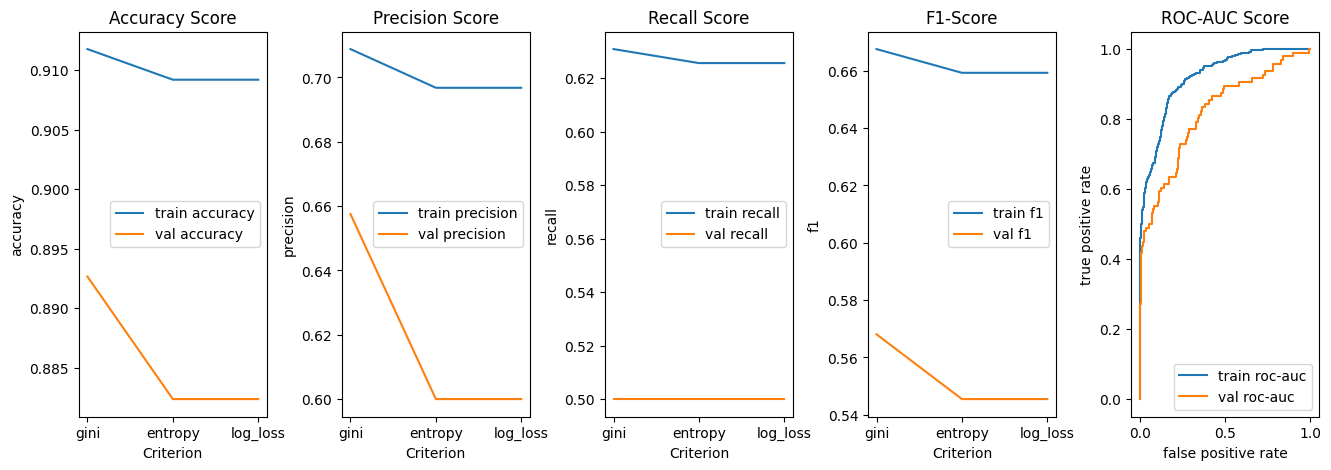

In [69]:
plot_performance(criterion, 'Criterion')

#### criterion = 'gini'

In [70]:
rf_criterion = RandomForestClassifier(random_state=8, class_weight='balanced', n_estimators=500, max_depth=5, min_samples_split=10, min_samples_leaf=2, max_features='sqrt', criterion='gini')
rf_criterion.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=500, random_state=8)

                accuracy  precision   recall  f1-score   roc-auc
Training Set    0.911765   0.708824  0.63089  0.667590  0.921693
Validation Set  0.892647   0.657534  0.50000  0.568047  0.815907


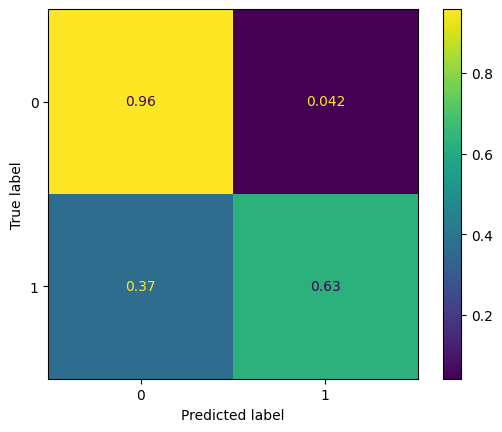

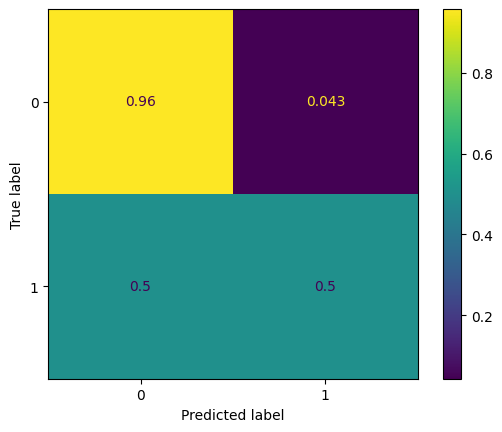

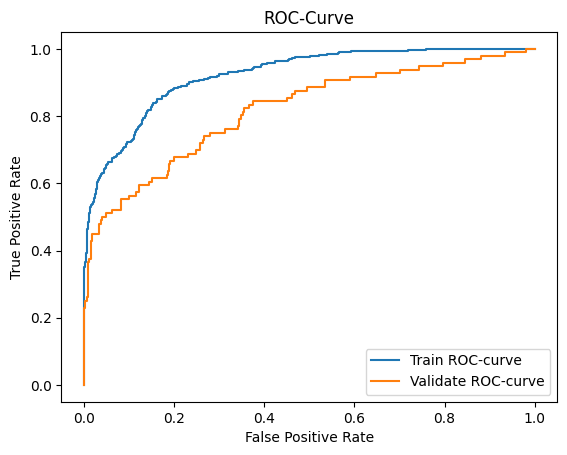

,accuracy,precision,recall,f1-score,roc-auc
Random Forest,0.892647,0.657534,0.5,0.568047,0.815907


In [71]:
random_forest(rf_criterion)

### Reduce overfitting with Max Samples

In [72]:
max_samples = [0.5, 0.8, 1.0]

In [73]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in max_samples:
    rf = RandomForestClassifier(random_state=8, class_weight='balanced', n_estimators=500, max_depth=5, min_samples_split=10, min_samples_leaf=2, max_features='sqrt', criterion='gini', max_samples=i).fit(X_train, y_train)
    y_train_preds = rf.predict(X_train)
    y_val_preds = rf.predict(X_val)
    
    y_train_probs = rf.predict_proba(X_train)[:, 1]
    y_val_probs = rf.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_max_samples = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=max_samples)

tune_max_samples

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
0.5,0.914706,0.889706,0.737342,0.647887,0.609948,0.479167,0.667622,0.550898,0.917106,0.798623
0.8,0.909926,0.886765,0.706949,0.626667,0.612565,0.489583,0.656381,0.549708,0.919247,0.813338
1.0,0.911765,0.892647,0.708824,0.657534,0.630890,0.500000,0.667590,0.568047,0.921693,0.815907


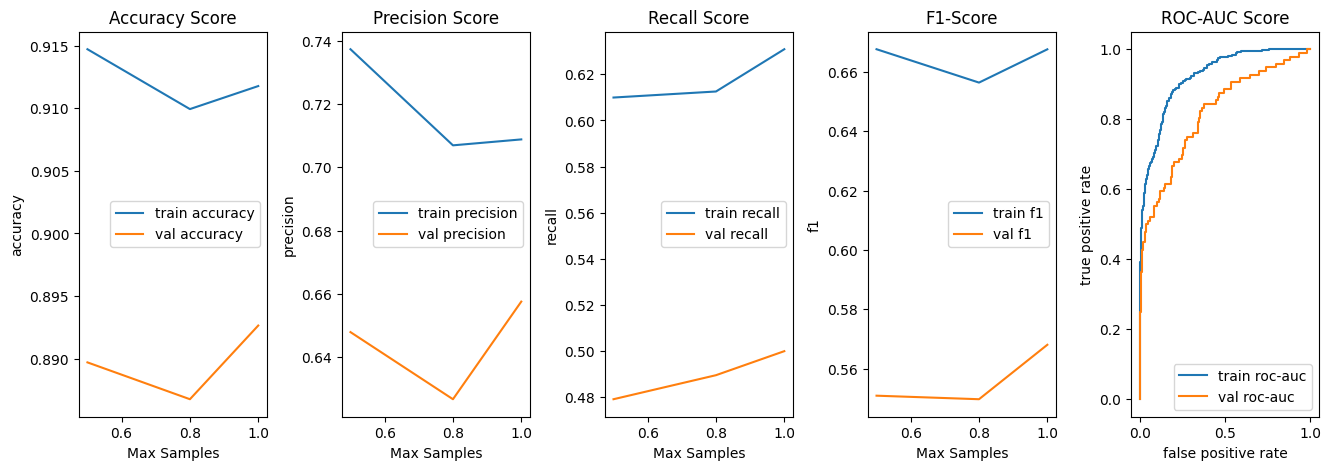

In [74]:
plot_performance(max_samples, 'Max Samples')

### Model After Hyperparameter Tuning

In [75]:
rf_tune = RandomForestClassifier(random_state=8, class_weight='balanced', n_estimators=500, max_depth=5, min_samples_split=10, min_samples_leaf=2, max_features='sqrt', criterion='gini')
rf_tune.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=500, random_state=8)

                accuracy  precision   recall  f1-score   roc-auc
Training Set    0.911765   0.708824  0.63089  0.667590  0.921693
Validation Set  0.892647   0.657534  0.50000  0.568047  0.815907


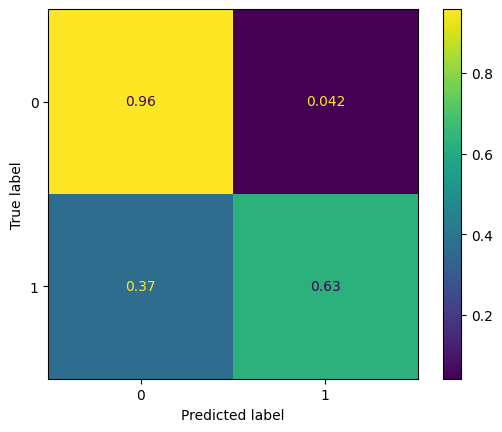

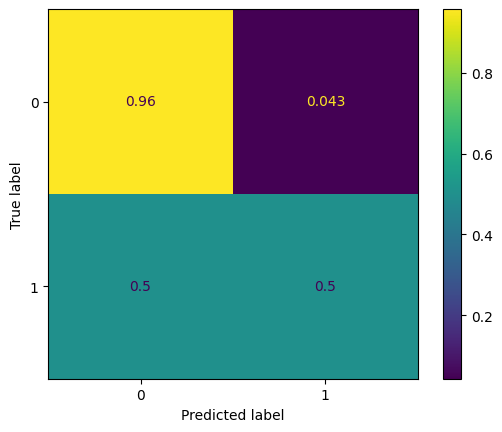

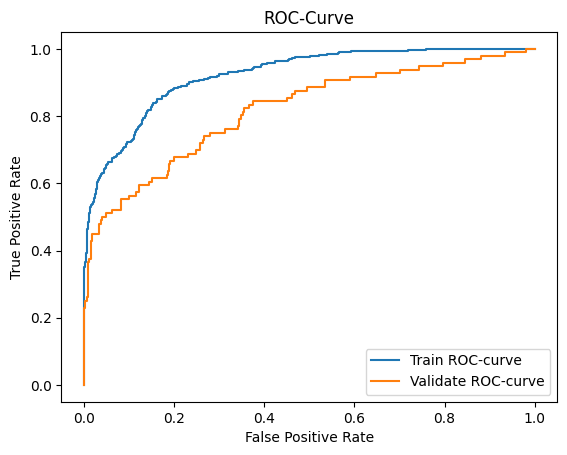

In [76]:
rf = random_forest(rf_tune)

**True Positive**: Correctly predicted "churn"

**True Negative**: Correctly predicted "not churn"

**False Positive**: Predicted "churn", but actually "not churn"

**False Negative**: Predicted "not churn", but actually "churn"



- For churn prediction, we'll prioritize recall over precision since False Negative are more costly than False Positive.

- The high False Negative (61%) in the validation set suggest that the model might not be able to capture the actual churn customers and predicted as not churn.

In [77]:
dump(rf_tune, '../models/random_forest.joblib')

['../models/random_forest.joblib']

In [78]:
rf.to_csv('../data/processed/model/4_rf.csv', index=False)